In [55]:
library("tidyr")
library("lubridate")
library("tidyverse")
library("dplyr")
library("ISLR")
library(glmnet)
library(ggplot2)
library(pROC)
library("tidyr")
require(rpart)
require(corrgram)


#### Import the data

In [56]:
OrigTrainData<- read.csv("train_kOBLwZA.csv")
head(OrigTrainData)
str(OrigTrainData)



Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
FDA15,9.300,Low Fat,0.01604730,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
DRC01,5.920,Regular,0.01927822,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
FDN15,17.500,Low Fat,0.01676007,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
FDX07,19.200,Regular,0.00000000,Fruits and Vegetables,182.0950,OUT010,1998,,Tier 3,Grocery Store,732.3800
NCD19,8.930,Low Fat,0.00000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
FDP36,10.395,Regular,0.00000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088


'data.frame':	8523 obs. of  12 variables:
 $ Item_Identifier          : Factor w/ 1559 levels "DRA12","DRA24",..: 157 9 663 1122 1298 759 697 739 441 991 ...
 $ Item_Weight              : num  9.3 5.92 17.5 19.2 8.93 ...
 $ Item_Fat_Content         : Factor w/ 5 levels "LF","low fat",..: 3 5 3 5 3 5 5 3 5 5 ...
 $ Item_Visibility          : num  0.016 0.0193 0.0168 0 0 ...
 $ Item_Type                : Factor w/ 16 levels "Baking Goods",..: 5 15 11 7 10 1 14 14 6 6 ...
 $ Item_MRP                 : num  249.8 48.3 141.6 182.1 53.9 ...
 $ Outlet_Identifier        : Factor w/ 10 levels "OUT010","OUT013",..: 10 4 10 1 2 4 2 6 8 3 ...
 $ Outlet_Establishment_Year: int  1999 2009 1999 1998 1987 2009 1987 1985 2002 2007 ...
 $ Outlet_Size              : Factor w/ 4 levels "","High","Medium",..: 3 3 3 1 2 3 2 3 1 1 ...
 $ Outlet_Location_Type     : Factor w/ 3 levels "Tier 1","Tier 2",..: 1 3 1 3 3 3 3 3 2 2 ...
 $ Outlet_Type              : Factor w/ 4 levels "Grocery Store",..: 2 3 2 1 2 3 

#### Converting item_identifier and outlet_identifier to characters

In [57]:
OrigTrainData$Item_Identifier<-as.character(OrigTrainData$Item_Identifier)
OrigTrainData$Outlet_Identifier<-as.character(OrigTrainData$Outlet_Identifier)

#### Check number of factors for each predictors.

In [58]:
levels(OrigTrainData$Item_Fat_Content) 
levels(OrigTrainData$Item_Type)
levels(OrigTrainData$Outlet_Size)
levels(OrigTrainData$Outlet_Type)
levels(OrigTrainData$Outlet_Location_Type)

[1] "LF"      "low fat" "Low Fat" "reg"     "Regular"

[1] "Baking Goods"          "Breads"                "Breakfast"            
 [4] "Canned"                "Dairy"                 "Frozen Foods"         
 [7] "Fruits and Vegetables" "Hard Drinks"           "Health and Hygiene"   
[10] "Household"             "Meat"                  "Others"               
[13] "Seafood"               "Snack Foods"           "Soft Drinks"          
[16] "Starchy Foods"

[1] ""       "High"   "Medium" "Small"

[1] "Grocery Store"     "Supermarket Type1" "Supermarket Type2"
[4] "Supermarket Type3"

[1] "Tier 1" "Tier 2" "Tier 3"

#### The terms "LF" "LOW FAT "low Fat" and "reg" "Regular" are the same. Hence it needs to be converted to two factors 

In [59]:
OrigTrainData$Item_Fat_Content<-
  ifelse(OrigTrainData$Item_Fat_Content==levels(OrigTrainData$Item_Fat_Content)[1] |
           OrigTrainData$Item_Fat_Content==levels(OrigTrainData$Item_Fat_Content)[2]|
           OrigTrainData$Item_Fat_Content==levels(OrigTrainData$Item_Fat_Content)[3],"LowFat","Regular")



#### Check the levels 

In [60]:
OrigTrainData$Item_Fat_Content<-as_factor(OrigTrainData$Item_Fat_Content)
levels(OrigTrainData$Item_Fat_Content) 

[1] "LowFat"  "Regular"

#### Check for missing datas.

In [61]:
sapply(OrigTrainData, function(x) sum(is.na(x)))

Item_Identifier               Item_Weight          Item_Fat_Content 
                        0                      1463                         0 
          Item_Visibility                 Item_Type                  Item_MRP 
                        0                         0                         0 
        Outlet_Identifier Outlet_Establishment_Year               Outlet_Size 
                        0                         0                         0 
     Outlet_Location_Type               Outlet_Type         Item_Outlet_Sales 
                        0                         0                         0

#### Only item weights are missing.

#### Filling for item Weights. We see that there exists NA values in Item_weights

In [62]:
sum(is.na(OrigTrainData$Item_Weight))

[1] 1463

#### It seems item weights are NA for 1463 records
#### The Item_ID corresponding to these NA weights are

In [63]:
ItemID_of_NA_weights<-unique((OrigTrainData %>% filter(is.na(Item_Weight)))$Item_Identifier)

#### We see that for item Id in ItemID_of_NA_weights there exist only at most one non NA value in dataset

In [64]:
MissingWeightTable<-OrigTrainData %>% filter(Item_Identifier %in% ItemID_of_NA_weights) %>% 
  group_by(Item_Identifier) %>% select(Item_Identifier,Item_Weight) %>% unique() %>% 
  summarise(number_of_unique_item_weights=n()) %>% arrange(desc(number_of_unique_item_weights))

#### We see for all item Id not in ItemID_of_NA_weights there exist only one value in dataset

In [65]:
OrigTrainData %>% filter(Item_Identifier %in% setdiff(unique(OrigTrainData$Item_Identifier),ItemID_of_NA_weights)) %>% 
  group_by(Item_Identifier) %>% select(Item_Identifier,Item_Weight) %>% unique() %>% 
  summarise(number_of_unique_item_weights=n()) %>% arrange(desc(number_of_unique_item_weights))

Item_Identifier,number_of_unique_item_weights
DRA12,1
DRB13,1
DRB24,1
DRC12,1
DRC13,1
DRC24,1
DRC27,1
DRD01,1
DRD37,1
DRD49,1


#### We see that with Item_ID with NA weight there exist only at most 1 non NA value in the table. Moreover 1138 of the corresponding Item_Ids have a non NA value in the database. For the remaining 4 we fill the mean for the item  for the corresponding Item_type and Item_Fat

In [66]:
ItemIDWeightAvailable<-unique((MissingWeightTable%>%filter(number_of_unique_item_weights==2))$Item_Identifier)

ItemWeightValueTable<-OrigTrainData %>% select(Item_Identifier,Item_Weight) %>% unique() %>%
  filter(Item_Identifier %in% ItemIDWeightAvailable & !is.na(Item_Weight)) %>%
  select(ItemID="Item_Identifier", ItemWeight="Item_Weight")



#### Finding the mean of item_weight grouped by item type and fat content

In [67]:
MeanValueTable<-OrigTrainData %>% group_by(Item_Fat_Content,Item_Type) %>%
  summarize(meanWt=mean(Item_Weight,na.rm=TRUE)) %>% 
  select(ItemType="Item_Type", Fat="Item_Fat_Content", meanWt)

OrigTrainData<-OrigTrainData %>% rowwise() %>% 
  mutate(Item_Weight=
           if(is.na(Item_Weight) & (Item_Identifier %in% ItemIDWeightAvailable))
             ((ItemWeightValueTable %>% filter(ItemID==Item_Identifier))$ItemWeight)
         else (if (is.na(Item_Weight)) 
           MeanValueTable$meanWt[which(MeanValueTable$ItemType==Item_Type & MeanValueTable$Fat==Item_Fat_Content)]
           else Item_Weight))

OrigTrainData<-as_tibble(OrigTrainData)

sum(is.na(OrigTrainData$Item_Weight))



[1] 0

#### Working on Item_visibility
#### Item_visibility = 0 is not a practical value.  So we need to substitute them with appropriate values.  
#### TotalEntries with Item_visibility=0

In [68]:
sum(OrigTrainData$Item_Visibility==0)

[1] 526

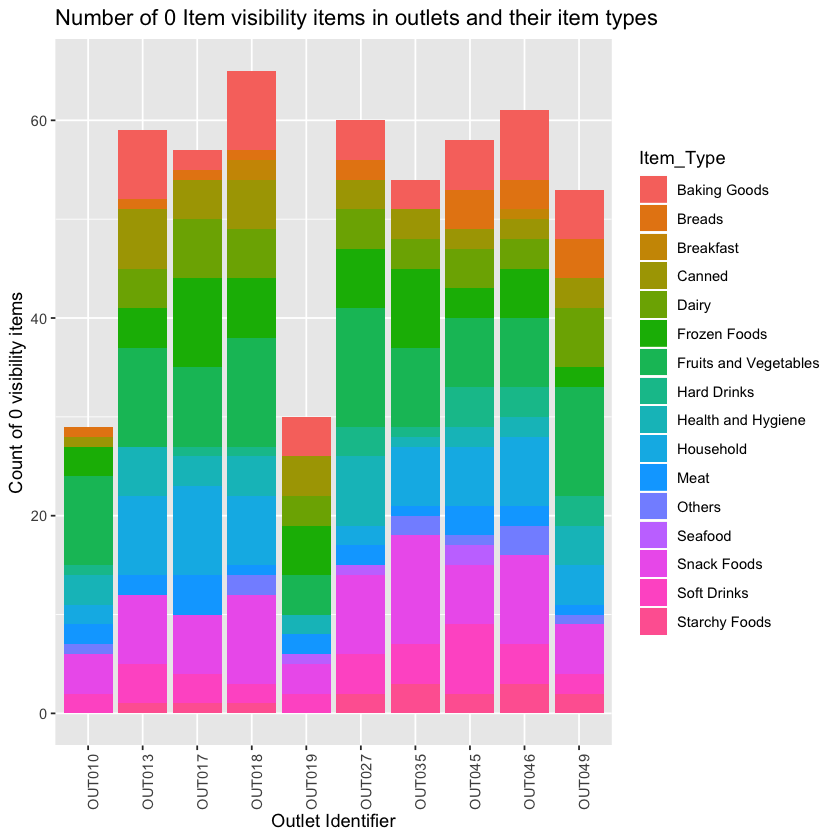

In [69]:
visibility0plot<-OrigTrainData %>% filter(Item_Visibility==0) %>% group_by(Outlet_Identifier, Item_Type) %>%
  summarize(countOf0visibility=n())
ggplot(visibility0plot)+
  geom_bar(aes(Outlet_Identifier,countOf0visibility, fill=Item_Type), stat = "identity") +
  labs(title = "Number of 0 Item visibility items in outlets and their item types", x = "Outlet Identifier", y = "Count of 0 visibility items")+
  theme(axis.text.x = element_text(angle = 90))

#### We see that items with  visibility 0 are spread across different outlets and different item_types

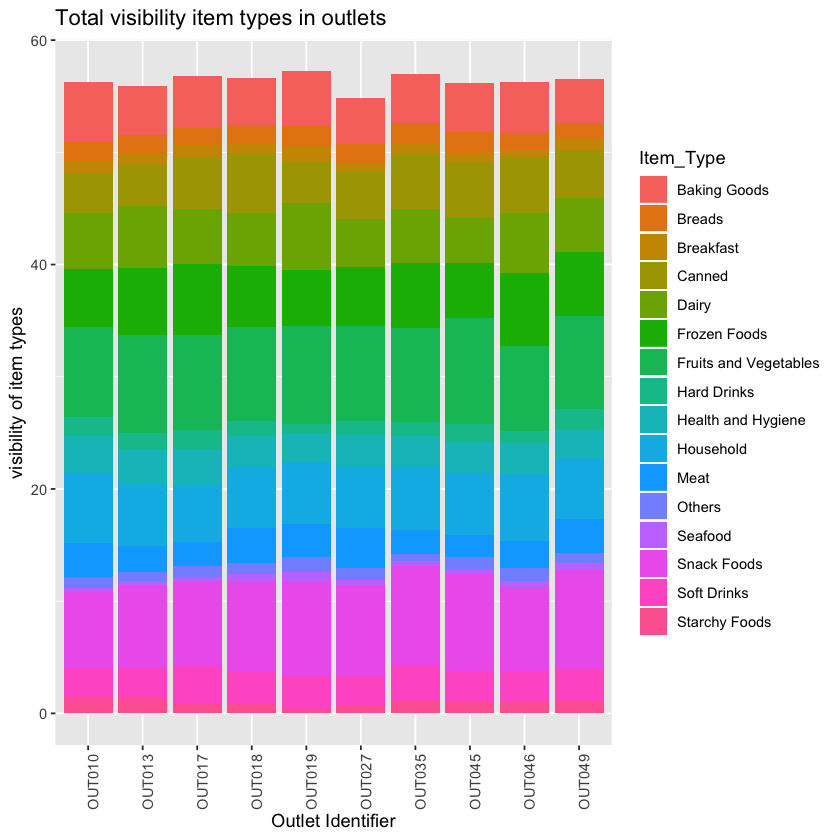

In [70]:
visibilityPlot<-OrigTrainData %>% group_by(Outlet_Identifier, Item_Type) %>%
  summarize(ItemTypeTotVis=sum(Item_Visibility))
ggplot(visibilityPlot)+
  geom_bar(aes(Outlet_Identifier,ItemTypeTotVis, fill=Item_Type), stat = "identity") +
  labs(title = "Total visibility item types in outlets", x = "Outlet Identifier", y = "visibility of item types")+
  theme(axis.text.x = element_text(angle = 90))


#### Moreover each item_type visibility is similar across Outlets

#### The number of 0 value unique item_Id


In [71]:
itemVisId0<-unique(OrigTrainData$Item_Identifier[which(OrigTrainData$Item_Visibility==0)])

#### 446 items
#### Out of 446  how many have visibility>0 for other outlets

In [72]:
itemVisId0withvalue<-unique(OrigTrainData$Item_Identifier[which(OrigTrainData$Item_Visibility>0 &
                                                                  OrigTrainData$Item_Identifier %in% itemVisId0)])

#### We have again 446
#### What we do based on our graphical analysis is fill the 0 values with the mean visibility 
#### Value for that same item_type across other outlets

In [73]:
ReferenceVisibilityValues<-
  OrigTrainData %>% filter(Item_Identifier %in% itemVisId0) %>% group_by(Item_Identifier) %>%
  summarise(meanVis=mean(Item_Visibility, na.rm=TRUE)) %>% select(ItemID="Item_Identifier", meanVis)

OrigTrainData<-OrigTrainData %>% rowwise() %>%
  mutate(Item_Visibility=if (Item_Visibility==0)
    (ReferenceVisibilityValues$meanVis[which(ReferenceVisibilityValues$ItemID==Item_Identifier)])
    else Item_Visibility)



#### Final check of number of 0 visibility item records 

In [74]:
sum(OrigTrainData$Item_Visibility==0)

OrigTrainData<-as_tibble(OrigTrainData)

[1] 0

#### Data Cleaning 
#### Outlet Size

In [75]:
OrigTrainData %>% group_by(Outlet_Identifier, Outlet_Type, Outlet_Location_Type, Outlet_Size) %>% 
  summarise(total_sales=sum(Item_Outlet_Sales),
            total_revenue=sum(Item_Outlet_Sales*Item_MRP),
            total_weight=sum(Item_Weight*Item_Outlet_Sales),
            TotalItemVisibility=sum(Item_Visibility)) %>% view()

#### We see that OUT010, OUT017 and OUT045 do not have outlet size filled

#### We see from comparing the outlet_type, total sales, total_revenue and total_weight of sales that OUT010, OUT017 and OUT045 are of Outlet_size "Small" hence filling all empty outlet_size as "Small"

In [76]:
OrigTrainData$Outlet_Size[which(OrigTrainData$Outlet_Size=="")]<-"Small"

#### Coverting the factors at Outlet Size to be  "High" "Medium" "Small"

In [77]:
OrigTrainData$Outlet_Size <- as_factor(as.character(OrigTrainData$Outlet_Size))
levels(OrigTrainData$Outlet_Size) ##check

OrigTrainData<-as_tibble(OrigTrainData)

unique(OrigTrainData %>% select(Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type))

OrigTrainData %>% select(Item_Identifier, Item_Type, Item_Fat_Content, Outlet_Identifier, Item_Outlet_Sales) %>% 
  unique() %>% group_by(Outlet_Identifier, Item_Type, Item_Fat_Content) %>% 
  summarise(count=n(), MeanSales=mean(Item_Outlet_Sales), VarianceSales=var(Item_Outlet_Sales)) %>% view()

[1] "Medium" "Small"  "High"

Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
OUT049,Medium,Tier 1,Supermarket Type1
OUT018,Medium,Tier 3,Supermarket Type2
OUT010,Small,Tier 3,Grocery Store
OUT013,High,Tier 3,Supermarket Type1
OUT027,Medium,Tier 3,Supermarket Type3
OUT045,Small,Tier 2,Supermarket Type1
OUT017,Small,Tier 2,Supermarket Type1
OUT046,Small,Tier 1,Supermarket Type1
OUT035,Small,Tier 2,Supermarket Type1
OUT019,Small,Tier 1,Grocery Store


## Data Visualization

#### Visualization Types of items sold in different Outlets.

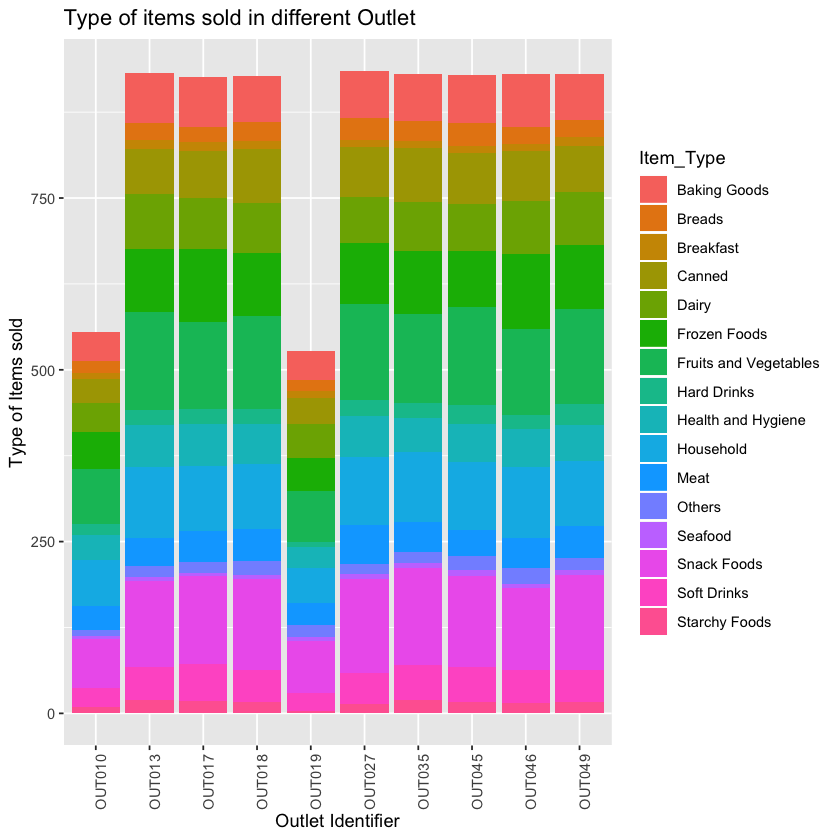

In [78]:
ggplot(OrigTrainData, aes(Outlet_Identifier, fill = Item_Type)) + geom_bar()+
  labs(title = "Type of items sold in different Outlet ", x = "Outlet Identifier", y = "Type of Items sold")+
  theme(axis.text.x = element_text(angle = 90))

#### Impact of item visiibility on Output sales.

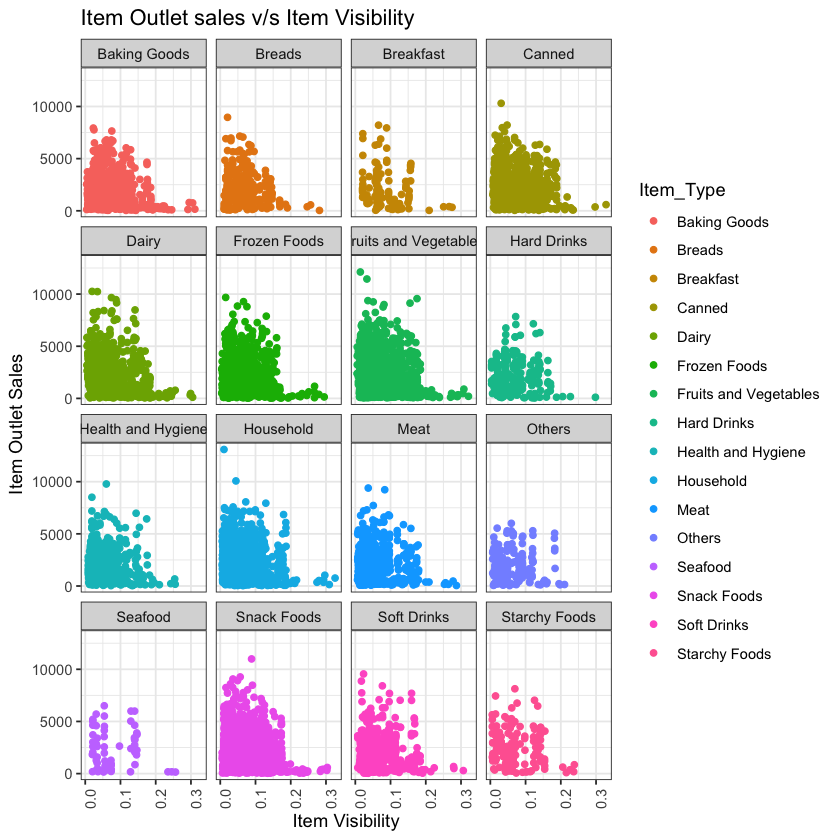

In [79]:
ggplot(OrigTrainData , aes(Item_Visibility, Item_Outlet_Sales)) + geom_point(aes(color = Item_Type)) + 
  scale_x_continuous("Item Visibility", breaks = seq(0,0.50,0.10))+
  scale_y_continuous("Item Outlet Sales", breaks = seq(0,15000,by = 5000))+ 
  theme_bw() + labs(title="Item Outlet sales v/s Item Visibility") + facet_wrap( ~ Item_Type)+
  theme(axis.text.x = element_text(angle = 90))

#### Impact of item visiibility on Output sales. - OUT 010

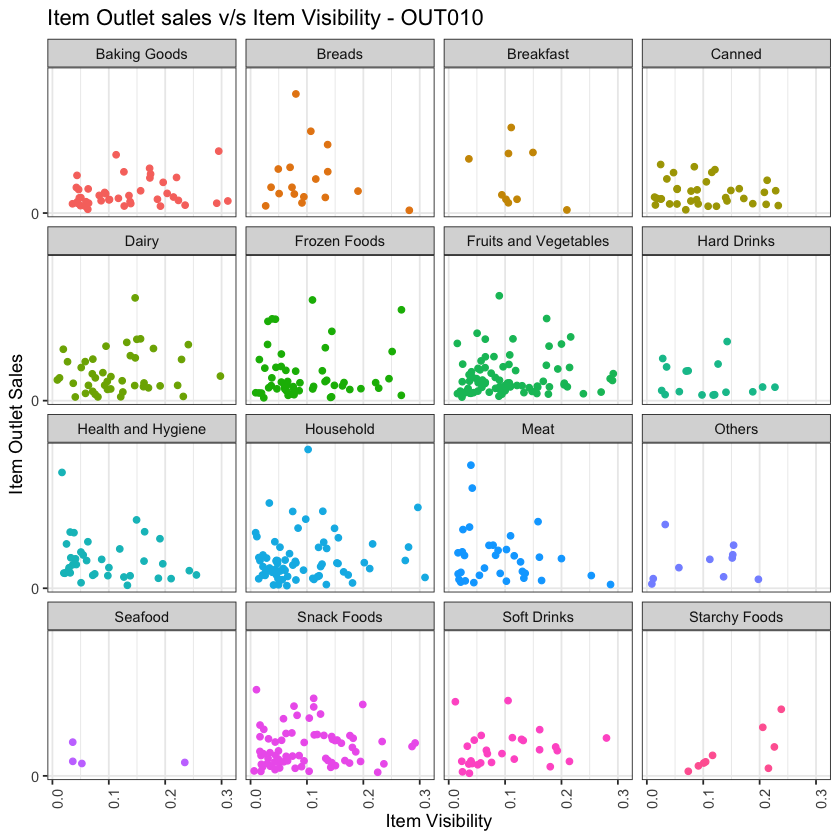

In [80]:
ggplot(OrigTrainData %>% filter(Outlet_Identifier=="OUT010"), aes(Item_Visibility, Item_Outlet_Sales)) + geom_point(aes(color = Item_Type)) + 
  scale_x_continuous("Item Visibility", breaks = seq(0,0.50,0.10))+
  scale_y_continuous("Item Outlet Sales", breaks = seq(0,15000,by = 5000))+ 
  theme_bw() + labs(title="Item Outlet sales v/s Item Visibility - OUT010") + facet_wrap( ~ Item_Type)+
  theme(axis.text.x = element_text(angle = 90), legend.position = "none")

#### Impact of item visiibility on Output sales. - OUT 018

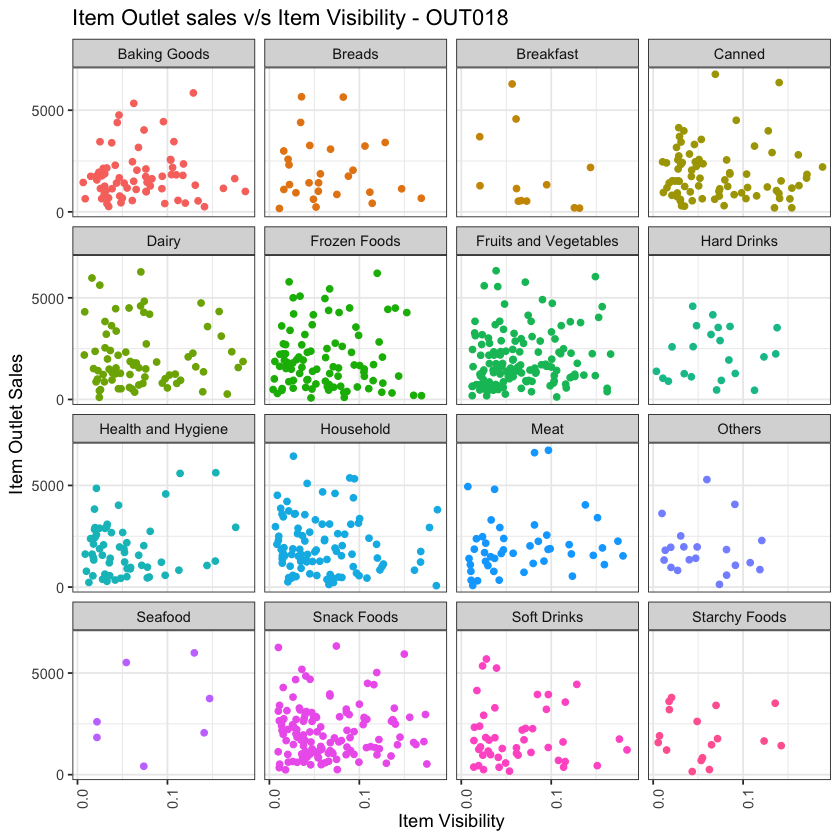

In [81]:
ggplot(OrigTrainData %>% filter(Outlet_Identifier=="OUT018"), aes(Item_Visibility, Item_Outlet_Sales)) + geom_point(aes(color = Item_Type)) + 
  scale_x_continuous("Item Visibility", breaks = seq(0,0.50,0.10))+
  scale_y_continuous("Item Outlet Sales", breaks = seq(0,15000,by = 5000))+ 
  theme_bw() + labs(title="Item Outlet sales v/s Item Visibility - OUT018") + facet_wrap( ~ Item_Type)+
  theme(axis.text.x = element_text(angle = 90), legend.position = "none")

## Data Modeling

#### Setting train and test data


In [82]:
set.seed(100)
n <- nrow(OrigTrainData)

train <- sample(1:n,round(0.9*n),replace = FALSE)
test <- setdiff(1:n, train)
TrainData <- OrigTrainData[train,]
TestData <- OrigTrainData[test,]
TestData<-TestData[TestData$Item_Identifier!="DRF48",]

#### Linear Regression

In [83]:
lm_model <- lm(Item_Outlet_Sales~., TrainData[-c(8,9,10,11)])
summary(lm_model)

data.frame(summary(lm_model)$coef[summary(lm_model)$coef[,4] <= .05, 4])
pred<-predict(lm_model,TestData)
(RMSE_LM<-(mean((pred - TestData$Item_Outlet_Sales)^2))^.5)




Call:
lm(formula = Item_Outlet_Sales ~ ., data = TrainData[-c(8, 9, 
    10, 11)])

Residuals:
    Min      1Q  Median      3Q     Max 
-3847.8  -593.5   -51.3   540.8  6780.6 

Coefficients: (17 not defined because of singularities)
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     2352.6491  1797.5144   1.309  0.19064    
Item_IdentifierDRA24             -11.0041   757.0703  -0.015  0.98840    
Item_IdentifierDRA59             277.9712   886.7247   0.313  0.75393    
Item_IdentifierDRB01           -1254.9155  1037.9717  -1.209  0.22671    
Item_IdentifierDRB13             252.2887   987.4687   0.255  0.79835    
Item_IdentifierDRB24             329.4072   813.5456   0.405  0.68556    
Item_IdentifierDRB25           -1374.3191   842.7920  -1.631  0.10301    
Item_IdentifierDRB48           -3084.0270  1434.3348  -2.150  0.03158 *  
Item_IdentifierDRC01           -3093.6715  1333.5346  -2.320  0.02038 *  
Item_IdentifierDRC12     

,summary.lm_model..coef.summary.lm_model..coef...4.....0.05..4.
Item_IdentifierDRB48,0.03158296
Item_IdentifierDRC01,0.02037893
Item_IdentifierDRD01,0.02553504
Item_IdentifierDRD12,0.04208345
Item_IdentifierDRD13,0.02925265
Item_IdentifierDRD49,0.04970152
Item_IdentifierDRE03,0.02987568
Item_IdentifierDRE12,0.02714473
Item_IdentifierDRE13,0.03420318
Item_IdentifierDRE15,0.04269664


Warning message in predict.lm(lm_model, TestData):
“prediction from a rank-deficient fit may be misleading”


[1] 1246.794

#### Linear Regression Log transformation

In [84]:
lm_model_log <- lm(log(Item_Outlet_Sales)~., TrainData)
summary(lm_model)
pred<-predict(lm_model_log,TestData)
RMSE_LM_log<-(mean((exp(pred) - TestData$Item_Outlet_Sales)^2))^.5


Call:
lm(formula = Item_Outlet_Sales ~ ., data = TrainData[-c(8, 9, 
    10, 11)])

Residuals:
    Min      1Q  Median      3Q     Max 
-3847.8  -593.5   -51.3   540.8  6780.6 

Coefficients: (17 not defined because of singularities)
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     2352.6491  1797.5144   1.309  0.19064    
Item_IdentifierDRA24             -11.0041   757.0703  -0.015  0.98840    
Item_IdentifierDRA59             277.9712   886.7247   0.313  0.75393    
Item_IdentifierDRB01           -1254.9155  1037.9717  -1.209  0.22671    
Item_IdentifierDRB13             252.2887   987.4687   0.255  0.79835    
Item_IdentifierDRB24             329.4072   813.5456   0.405  0.68556    
Item_IdentifierDRB25           -1374.3191   842.7920  -1.631  0.10301    
Item_IdentifierDRB48           -3084.0270  1434.3348  -2.150  0.03158 *  
Item_IdentifierDRC01           -3093.6715  1333.5346  -2.320  0.02038 *  
Item_IdentifierDRC12     

Warning message in predict.lm(lm_model_log, TestData):
“prediction from a rank-deficient fit may be misleading”


#### Lasso

In [85]:
LassoData<-OrigTrainData[-c(8)]
#LassoData$Outlet_Establishment_Year<-as.factor(LassoData$Outlet_Establishment_Year)

H<-LassoData

x <- model.matrix(Item_Outlet_Sales~ ., H)[,-11]
y <- H$Item_Outlet_Sales



#### Perform CV on the training data using cv.glmnet()

$lambda
 [1] 964.2563747 878.5944961 800.5425826 729.4245860 664.6245163 605.5811061
 [7] 551.7829497 502.7640733 458.0998987 417.4035663 380.3225839 346.5357738
[13] 315.7504908 287.7000875 262.1416047 238.8536670 217.6345656 198.3005106
[19] 180.6840398 164.6325677 150.0070641 136.6808500 124.5385000 113.4748429
[25] 103.3940506  94.2088082  85.8395573  78.2138076  71.2655085  64.9344772
[31]  59.1658772  53.9097437  49.1205507  44.7568163  40.7807441  37.1578952
[37]  33.8568902  30.8491374  28.1085851  25.6114959  23.3362412  21.2631138
[43]  19.3741574  17.6530106  16.0847658  14.6558396  13.3538552  12.1675355
[49]  11.0866052  10.1017017   9.2042944   8.3866102   7.6415669   6.9627112
[55]   6.3441631   5.7805651   5.2670357   4.7991267   4.3727855   3.9843193
[61]   3.6303634   3.3078519   3.0139914   2.7462368   2.5022687   2.2799740
[67]   2.0774274   1.8928745   1.7247167   1.5714976   1.4318901   1.3046849
[73]   1.1887803   1.0831724   0.9869463   0.8992687   0.8193802   0

1594 x 1 sparse Matrix of class "dgCMatrix"
                                          1
(Intercept)                    -1214.077731
(Intercept)                        .       
Item_IdentifierDRA24               .       
Item_IdentifierDRA59               .       
Item_IdentifierDRB01            -265.178130
Item_IdentifierDRB13               .       
Item_IdentifierDRB24               .       
Item_IdentifierDRB25               .       
Item_IdentifierDRB48               .       
Item_IdentifierDRC01               .       
Item_IdentifierDRC12               .       
Item_IdentifierDRC24               .       
Item_IdentifierDRC25               .       
Item_IdentifierDRC27               .       
Item_IdentifierDRC36               .       
Item_IdentifierDRC49               .       
Item_IdentifierDRD01               .       
Item_IdentifierDRD12               .       
Item_IdentifierDRD13               .       
Item_IdentifierDRD15               .       
Item_IdentifierDRD24            

[1] 1142.678

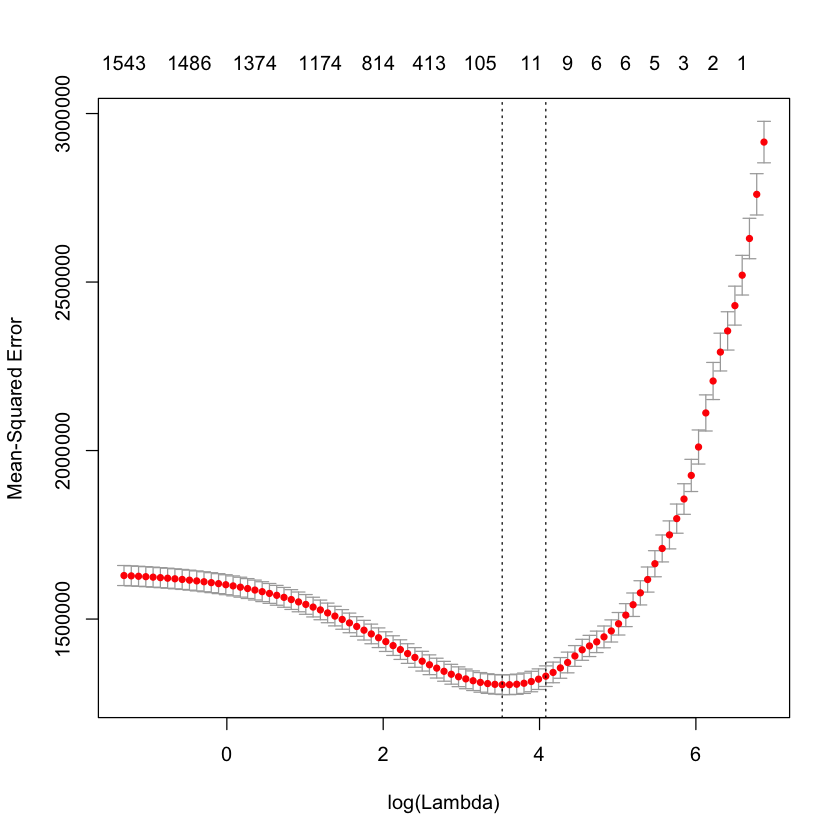

In [86]:
lasso.cv <- cv.glmnet(x[train,], y[train], alpha = 1)

print(lasso.cv)
plot(lasso.cv)   # plot training MSE as a function of lambda
lambda.min <- lasso.cv$lambda.min # the lamda that minimizes training MSE
coef(lasso.cv, s = lambda.min)
pred <- predict(lasso.cv, newx=x[test,], s = lambda.min)
(RMSE_Lasso <- (mean((pred - y[test])^2))^.5) # test MSE from lasso

#### Lasso Log

In [87]:
y <- log(H$Item_Outlet_Sales)

#### Perform CV on the training data using cv.glmnet()

$lambda
 [1] 0.5206089204 0.4743594588 0.4322186719 0.3938215564 0.3588355348
 [6] 0.3269575749 0.2979115651 0.2714459227 0.2473314151 0.2253591739
[11] 0.2053388860 0.1870971453 0.1704759506 0.1553313370 0.1415321292
[16] 0.1289588049 0.1175024601 0.1070638654 0.0975526067 0.0888863020
[21] 0.0809898879 0.0737949695 0.0672392278 0.0612658801 0.0558231882
[26] 0.0508640100 0.0463453916 0.0422281947 0.0384767583 0.0350585891
[31] 0.0319440807 0.0291062566 0.0265205370 0.0241645256 0.0220178157
[36] 0.0200618137 0.0182795774 0.0166556702 0.0151760263 0.0138278300
[41] 0.0125994037 0.0114801074 0.0104602463 0.0095309868 0.0086842802
[46] 0.0079127927 0.0072098420 0.0065693395 0.0059857375 0.0054539811
[51] 0.0049694644 0.0045279909 0.0041257367 0.0037592176 0.0034252591
[56] 0.0031209685 0.0028437103 0.0025910829 0.0023608982 0.0021511625
[61] 0.0019600592 0.0017859329 0.0016272756 0.0014827129 0.0013509928
[66] 0.0012309743 0.0011216179 0.0010219765 0.0009311869 0.0008484628
[71] 0.00077

1594 x 1 sparse Matrix of class "dgCMatrix"
                                          1
(Intercept)                     4.627726029
(Intercept)                     .          
Item_IdentifierDRA24            .          
Item_IdentifierDRA59            .          
Item_IdentifierDRB01           -0.435540309
Item_IdentifierDRB13            .          
Item_IdentifierDRB24            .          
Item_IdentifierDRB25            .          
Item_IdentifierDRB48            .          
Item_IdentifierDRC01            .          
Item_IdentifierDRC12            .          
Item_IdentifierDRC24            .          
Item_IdentifierDRC25            .          
Item_IdentifierDRC27           -0.176219251
Item_IdentifierDRC36            .          
Item_IdentifierDRC49            .          
Item_IdentifierDRD01            .          
Item_IdentifierDRD12            .          
Item_IdentifierDRD13            .          
Item_IdentifierDRD15            .          
Item_IdentifierDRD24            

[1] 1143.461

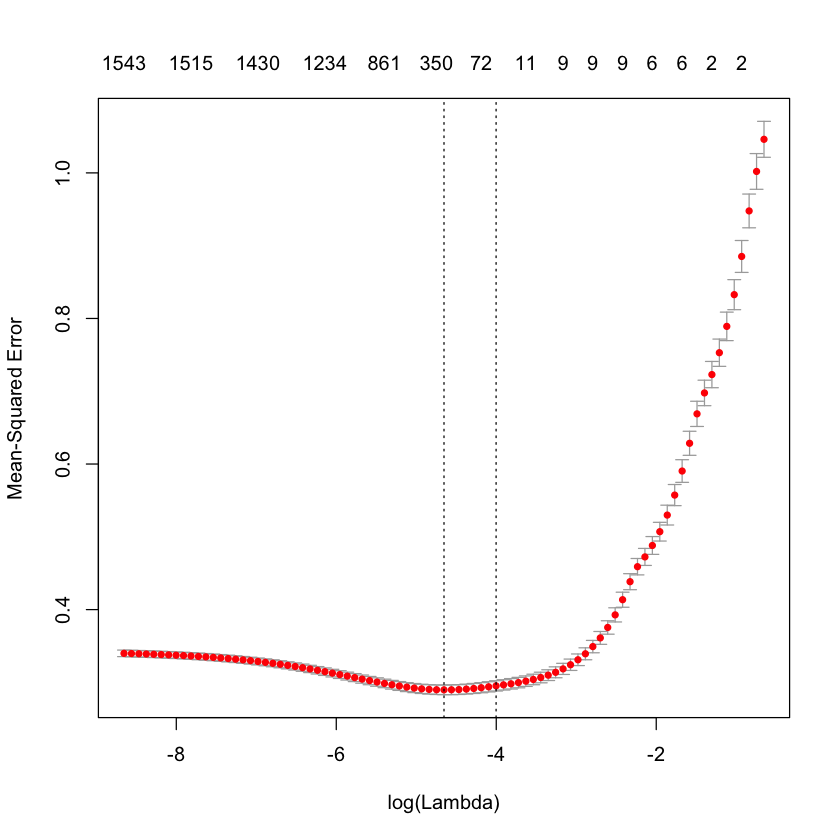

In [88]:
lassolog.cv <- cv.glmnet(x[train,], y[train], alpha = 1)
print(lassolog.cv)
plot(lassolog.cv)   # plot training MSE as a function of lambda
lambda.min <- lassolog.cv$lambda.min # the lamda that minimizes training MSE
coef(lassolog.cv, s = lambda.min)
pred <- predict(lassolog.cv, newx=x[test,], s = lambda.min)
(RMSE_Lasso_log <- (mean((exp(pred) - exp(y[test]))^2))^.5) # test MSE from lasso

#### Ridge

In [89]:
y <- H$Item_Outlet_Sales

#### Perform CV on the training data using cv.glmnet()

$lambda
 [1] 964256.3747 878594.4961 800542.5826 729424.5860 664624.5163 605581.1061
 [7] 551782.9497 502764.0733 458099.8987 417403.5663 380322.5839 346535.7738
[13] 315750.4908 287700.0875 262141.6047 238853.6670 217634.5656 198300.5106
[19] 180684.0398 164632.5677 150007.0641 136680.8500 124538.5000 113474.8429
[25] 103394.0506  94208.8082  85839.5573  78213.8076  71265.5085  64934.4772
[31]  59165.8772  53909.7437  49120.5507  44756.8163  40780.7441  37157.8952
[37]  33856.8902  30849.1374  28108.5851  25611.4959  23336.2412  21263.1138
[43]  19374.1574  17653.0106  16084.7658  14655.8396  13353.8552  12167.5355
[49]  11086.6052  10101.7017   9204.2944   8386.6102   7641.5669   6962.7112
[55]   6344.1631   5780.5651   5267.0357   4799.1267   4372.7855   3984.3193
[61]   3630.3634   3307.8519   3013.9914   2746.2368   2502.2687   2279.9740
[67]   2077.4274   1892.8745   1724.7167   1571.4976   1431.8901   1304.6849
[73]   1188.7803   1083.1724    986.9463    899.2687    819.3802    

[1] 1229.174

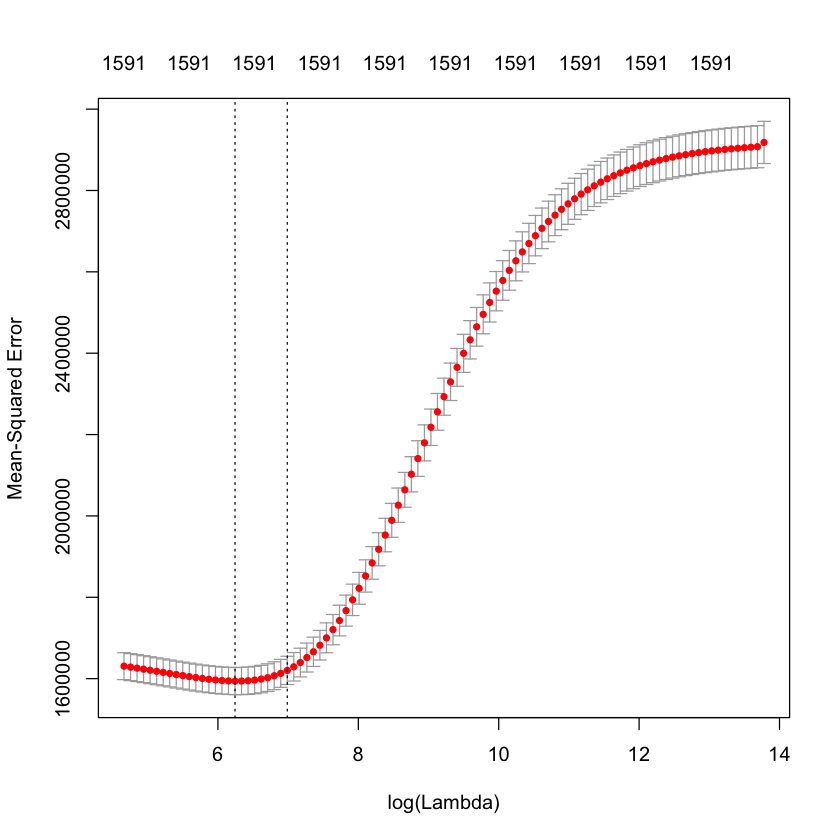

In [90]:
Ridge.cv <- cv.glmnet(x[train,], y[train], alpha = 0)

print(Ridge.cv)
plot(Ridge.cv)   # plot training MSE as a function of lambda
lambda.min <- Ridge.cv$lambda.min # the lamda that minimizes training MSE

pred <- predict(Ridge.cv, newx=x[test,], s = lambda.min)
(RMSE_Ridge<-(mean((pred - y[test])^2))^.5) # test MSE from Ridge



#### Ridge_Log

In [91]:
y <- log(H$Item_Outlet_Sales)

#### Perform CV on the training data using cv.glmnet()

$lambda
 [1] 520.60892040 474.35945881 432.21867191 393.82155638 358.83553476
 [6] 326.95757487 297.91156508 271.44592274 247.33141512 225.35917390
[11] 205.33888602 187.09714534 170.47595062 155.33133704 141.53212918
[16] 128.95880491 117.50246012 107.06386542  97.55260671  88.88630200
[21]  80.98988792  73.79496950  67.23922780  61.26588013  55.82318820
[26]  50.86401002  46.34539156  42.22819471  38.47675828  35.05858913
[31]  31.94408070  29.10625661  26.52053700  24.16452559  22.01781573
[36]  20.06181367  18.27957744  16.65567016  15.17602633  13.82782998
[41]  12.59940368  11.48010738  10.46024628   9.53098683   8.68428023
[46]   7.91279271   7.20984202   6.56933952   5.98573751   5.45398108
[51]   4.96946444   4.52799091   4.12573668   3.75921760   3.42525907
[56]   3.12096850   2.84371026   2.59108288   2.36089822   2.15116253
[61]   1.96005918   1.78593292   1.62727556   1.48271289   1.35099276
[66]   1.23097429   1.12161792   1.02197648   0.93118691   0.84846283
[71]   0.773

[1] 1226.582

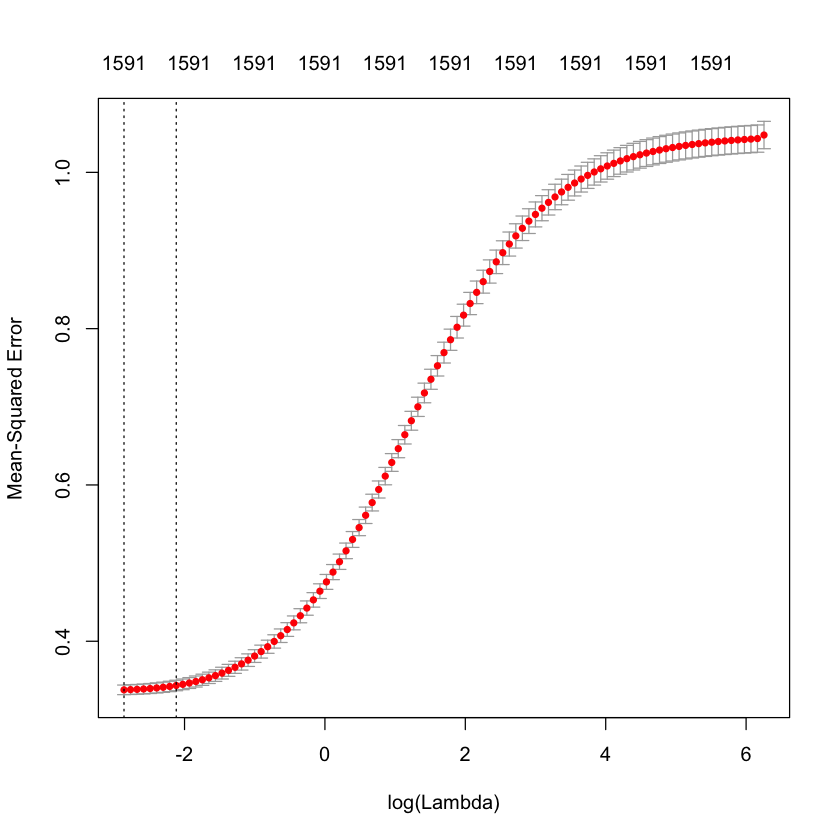

In [92]:
RidgeLog.cv <- cv.glmnet(x[train,], y[train], alpha = 0)

print(RidgeLog.cv)
plot(RidgeLog.cv)   # plot training MSE as a function of lambda
lambda.min <- RidgeLog.cv$lambda.min # the lamda that minimizes training MSE

pred <- predict(RidgeLog.cv, newx=x[test,], s = lambda.min)
(RMSE_Ridge_log<-(mean((exp(pred) - exp(y[test]))^2))^.5) # test MSE from Ridge log



#### Decision tree

In [93]:
TreeData<-OrigTrainData[-c(8)]
#TreeData$Item_Identifier<-as.factor(TreeData$Item_Identifier)
#TreeData$Outlet_Identifier<-as.factor(TreeData$Outlet_Identifier)
#TreeData$Outlet_Establishment_Year<-as.factor(TreeData$Outlet_Establishment_Year)
TrainData <- TreeData[train,-1]
TestData <- TreeData[test,-1]

fm.rpart <- rpart(Item_Outlet_Sales ~ ., data=TrainData)



#### Printed summaries of the fitted model

In [94]:
print(fm.rpart)
printcp(fm.rpart)
summary(fm.rpart)

n= 7671 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 7671 22377560000 2177.3350  
   2) Item_MRP< 143.5299 3864  3760845000 1353.9750  
     4) Outlet_Type=Grocery Store 504    10223670  208.6477 *
     5) Outlet_Type=Supermarket Type1,Supermarket Type2,Supermarket Type3 3360  2990317000 1525.7740  
      10) Item_MRP< 79.6473 1203   310428700  890.4962 *
      11) Item_MRP>=79.6473 2157  1923609000 1880.0800  
        22) Outlet_Identifier=OUT013,OUT017,OUT018,OUT035,OUT045,OUT046,OUT049 1899  1320825000 1741.0180 *
        23) Outlet_Identifier=OUT027 258   295758500 2903.6440 *
   3) Item_MRP>=143.5299 3807 13338510000 3013.0230  
     6) Outlet_Identifier=OUT010,OUT019 500    40870810  475.5237 *
     7) Outlet_Identifier=OUT013,OUT017,OUT018,OUT027,OUT035,OUT045,OUT046,OUT049 3307  9591427000 3396.6790  
      14) Outlet_Identifier=OUT013,OUT017,OUT018,OUT035,OUT045,OUT046,OUT049 2891  6570013000 3157.2680  
        28) Item_MRP< 207.0138 1889  2965946

#### Basic plot

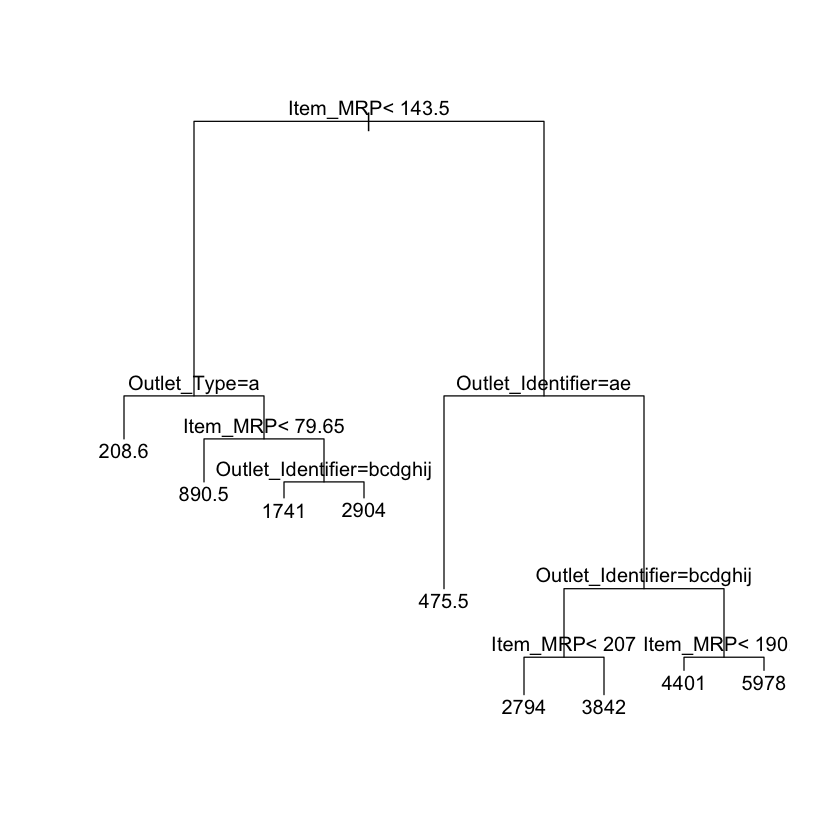


Model formula:
Item_Outlet_Sales ~ Item_Weight + Item_Fat_Content + Item_Visibility + 
    Item_Type + Item_MRP + Outlet_Identifier + Outlet_Size + 
    Outlet_Location_Type + Outlet_Type

Fitted party:
[1] root
|   [2] Item_MRP < 143.5299
|   |   [3] Outlet_Type in Grocery Store: 208.648 (n = 504, err = 10223674.4)
|   |   [4] Outlet_Type in Supermarket Type1, Supermarket Type2, Supermarket Type3
|   |   |   [5] Item_MRP < 79.6473: 890.496 (n = 1203, err = 310428663.7)
|   |   |   [6] Item_MRP >= 79.6473
|   |   |   |   [7] Outlet_Identifier in OUT013, OUT017, OUT018, OUT035, OUT045, OUT046, OUT049: 1741.018 (n = 1899, err = 1320825266.8)
|   |   |   |   [8] Outlet_Identifier in OUT027: 2903.644 (n = 258, err = 295758468.2)
|   [9] Item_MRP >= 143.5299
|   |   [10] Outlet_Identifier in OUT010, OUT019: 475.524 (n = 500, err = 40870806.6)
|   |   [11] Outlet_Identifier in OUT013, OUT017, OUT018, OUT027, OUT035, OUT045, OUT046, OUT049
|   |   |   [12] Outlet_Identifier in OUT013, OUT017

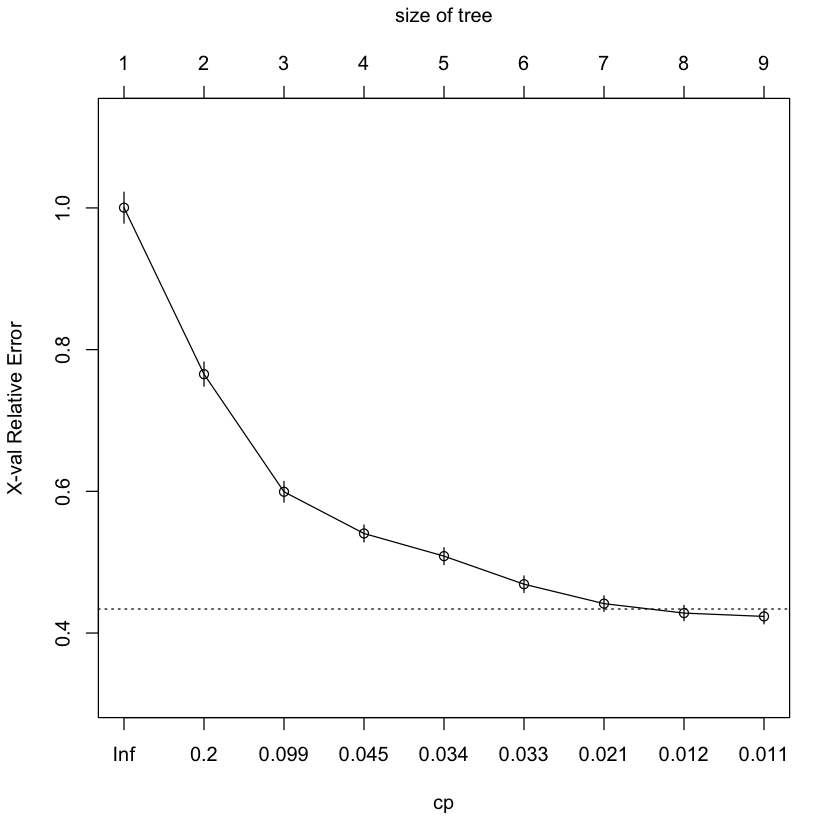

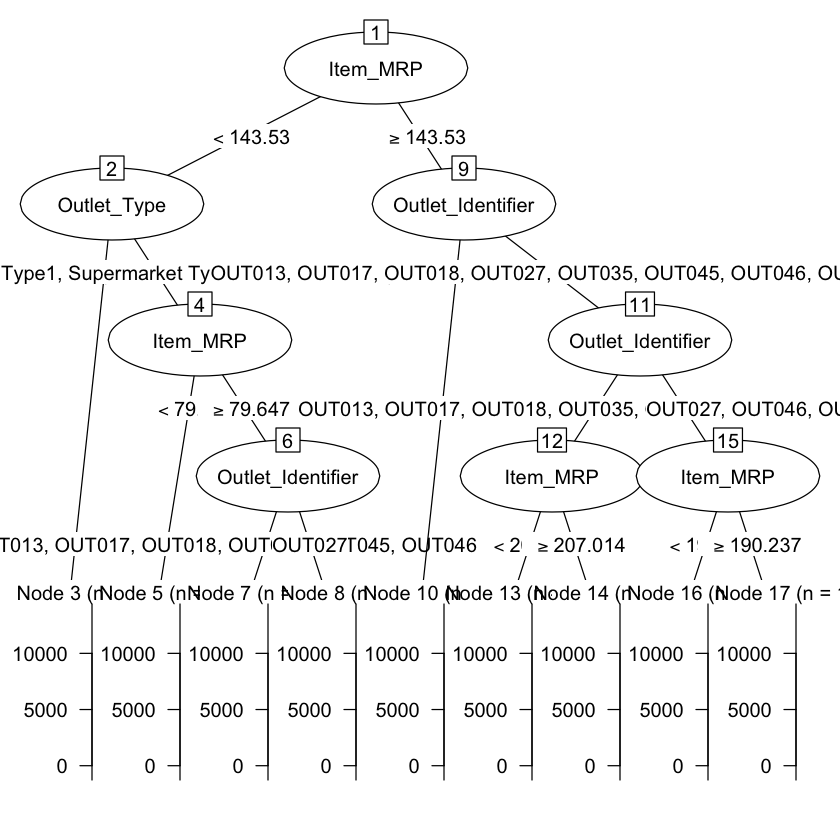

In [95]:
plot(fm.rpart)
text(fm.rpart)

plotcp(fm.rpart)

require(partykit)

fm.rparty <- as.party(fm.rpart)
print(fm.rparty)
plot(fm.rparty)

pred<-predict(fm.rpart,TestData)
RMSE_Tree<-(mean((pred - TestData$Item_Outlet_Sales)^2))^.5

#### Seeing LASSO gives the minimum RMSE and using the information learned from decision tree, we introduce a new LASSO model that captures interaction effects in our problem
#### Lasso2 : including the interaction variables.

In [96]:
x_new <- model.matrix(Item_Outlet_Sales~ 
                        Item_Weight*Outlet_Type + Item_Identifier*Outlet_Type + Item_Identifier*Item_MRP*Outlet_Type +
                        Item_Fat_Content*Outlet_Location_Type*Outlet_Type+Item_Type*Outlet_Type, H)
y <- H$Item_Outlet_Sales

#### Perform CV on the training data using cv.glmnet()

$lambda
 [1] 964.25637 920.42943 878.59450 838.66102 800.54258 764.15669 729.42459
 [8] 696.27111 664.62452 634.41631 605.58111 578.05651 551.78295 526.70356
[15] 502.76407 479.91267 458.09990 437.27855 417.40357 398.43193 380.32258
[22] 363.03634 346.53577 330.78519 315.75049 301.39914 287.70009 274.62367
[29] 262.14160 250.22686 238.85367 227.99740 217.63457 207.74274 198.30051
[36] 189.28745 180.68404 172.47167 164.63257 157.14976 150.00706 143.18901
[43] 136.68085 130.46849 124.53850 118.87803 113.47484 108.31724 103.39405
[50]  98.69463  94.20881  89.92687  85.83956  81.93802  78.21381  74.65887
[57]  71.26551  68.02638  64.93448  61.98310  59.16588  56.47670  53.90974
[64]  51.45946  49.12055  46.88795  44.75682  42.72255  40.78074  38.92720
[71]  37.15790  35.46901  33.85689  32.31804  30.84914  29.44700  28.10859
[78]  26.83101  25.61150  24.44741  23.33624  22.27557  21.26311  20.29667
[85]  19.37416  18.49357  17.65301  16.85065  16.08477  15.35369  14.65584
[92]  13.98971  1

12557 x 1 sparse Matrix of class "dgCMatrix"
                                                                                            1
(Intercept)                                                                      7.898176e+01
(Intercept)                                                                      .           
Item_Weight                                                                      .           
Outlet_TypeSupermarket Type1                                                     .           
Outlet_TypeSupermarket Type2                                                     .           
Outlet_TypeSupermarket Type3                                                     2.418305e+01
Item_IdentifierDRA24                                                             .           
Item_IdentifierDRA59                                                             .           
Item_IdentifierDRB01                                                             .           
Item_Identifier

[1] 1102.499

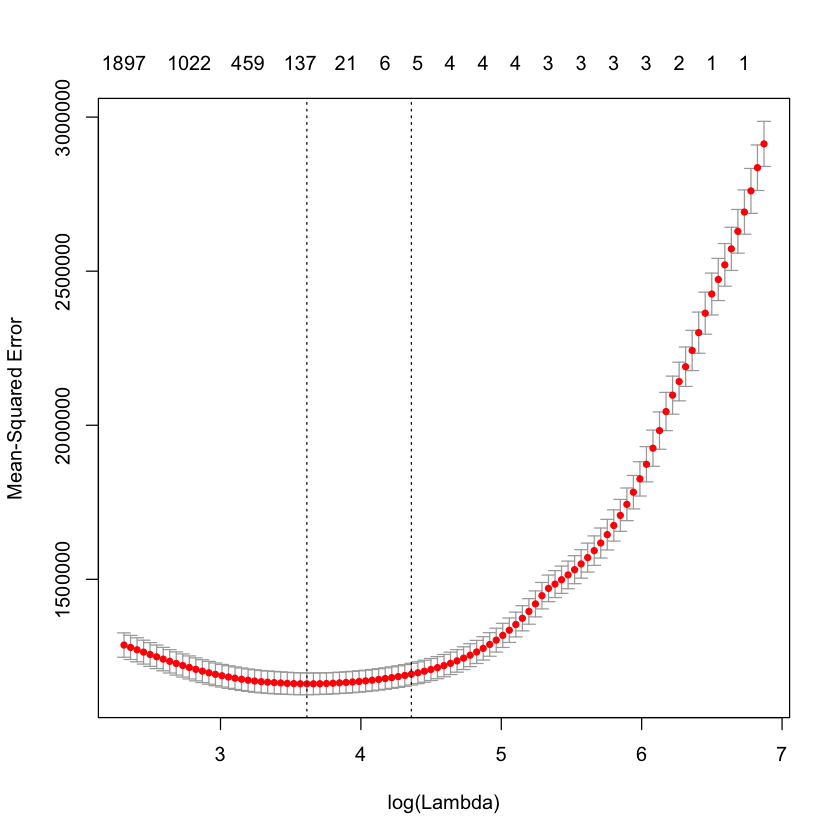

In [97]:
lasso2.cv <- cv.glmnet(x_new[train,], y[train], alpha = 1)

print(lasso2.cv)
plot(lasso2.cv)   # plot training MSE as a function of lambda
lambda.min <- lasso2.cv$lambda.min # the lamda that minimizes training MSE
coef(lasso2.cv, s = lambda.min)
pred <- predict(lasso2.cv, newx=x_new[test,], s = lambda.min)
(RMSE_Lasso2 <- (mean((pred - y[test])^2))^.5) # test MSE from lasso

